# NHL Jets - Event Propensity - Next Event Buyer Model
* Ryan Kazmerik, Nakisa Rad, Joey Lai, Shawn Sutherland, Matt Bahler, Pat Faith
* Mar 03, 2022

## Hypothesis
Each team has different tier (or quality) of games, based on day of the week, time of the season, opponent, etc. We think that by using previous buyer behaviour we can make a prediction on whether the fan will purchase for the next game or not.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import boto3
import getpass
import json
import matplotlib.pyplot as plt
import pyodbc
import pandas as pd
import awswrangler as wr
import warnings

from pycaret.classification import *

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

### Let's connect to MSSQL and run a stored proc to get our training dataset:

In [5]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [6]:
cursor = CNXN.cursor()

lkupclientid = 92
storedProc = (
    f"""Exec [stlrNHLJets].[ds].[PropensityEventTraining] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)
    
CNXN.commit()
cursor.close()

df.shape

(63646, 17)

In [64]:
df.head()

,daysOut,minDaysOut,maxDaysOut,dimCustomerMasterId,recent_openRate,recent_clickRate,eventDate,eventName,inMarket,distanceToVenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventDay,frequency_eventTime,count_merchOwned
0,1 to 3 Days Out,1,4.0,86,0.0,0.0,2017-10-20,20171020 - Minnesota Wild,False,606.79,208,1,10,0.0,0.000000,0.000000,0
1,1 to 3 Days Out,1,4.0,157,0.0,0.0,2013-11-18,20131118 - Calgary Flames,False,189.20,58,0,14,0.0,0.000000,0.076923,0
2,1 to 3 Days Out,1,4.0,235,0.0,0.0,2019-10-15,20191015 - Arizona Coyotes,True,6.97,2135,0,253,0.0,0.000000,0.000000,0
3,1 to 3 Days Out,1,4.0,659,0.0,0.0,2019-02-05,20190205 - San Jose Sharks,True,106.44,1520,0,193,0.0,0.000000,0.005780,0
4,1 to 3 Days Out,1,4.0,1165,0.0,0.0,2015-12-27,20151227 - Pittsburgh Penguins,False,189.20,464,0,64,0.0,0.090909,0.018182,0


### We should create separate out some data for training the model and some for evaluating:

In [8]:
# copy your main dataframe
df_dataset = df

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True)
df_eval.reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (54099, 17)
Unseen Data For Predictions: (9547, 17)



### Now we can model the data using a binary classification prediction for the target field to see how likely a customer is to purchase:

In [9]:
setup(
    data= df_train, 
    target="did_purchase", 
    train_size = 0.85,
    data_split_shuffle=True,
    categorical_features=["inMarket"],
    date_features=["eventDate"],
    ignore_features=[
        "dimCustomerMasterId",
        "eventName",
        "minDaysOut",
        "maxDaysOut"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "distanceToVenue",
        "events_purchased",
        "frequency_eventDay",
        "frequency_opponent",
        "frequency_eventTime",
        "recent_clickRate",
        "recent_openRate",
        "tenure"
    ]
);

In [10]:
model_matrix = compare_models(
    fold= 10,
    include= ["gbc","lightgbm","lr","xgboost"],
    n_select= 4,
    sort= "AUC"
)
results = pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8011,0.8853,0.7798,0.8151,0.7970,0.6022,0.6027,0.2340
xgboost,Extreme Gradient Boosting,0.7999,0.8847,0.7821,0.8117,0.7966,0.5998,0.6003,1.2710
gbc,Gradient Boosting Classifier,0.7919,0.8753,0.7570,0.8144,0.7846,0.5838,0.5853,1.0980
lr,Logistic Regression,0.7617,0.8395,0.7390,0.7749,0.7565,0.5234,0.5240,1.4200


### Let's create a collection of our models so we can compare them against actual game purchases:

In [12]:
models = []
for idx, m in enumerate(model_matrix):
    
    model = create_model(m)
    final_model = finalize_model(model)
    
    models.append({
        "name": str(results.iloc[idx]["Model"]),
        "model": final_model
    })

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7571,0.8361,0.7240,0.7762,0.7492,0.5143,0.5155
1,0.7591,0.8307,0.7322,0.7746,0.7528,0.5182,0.5190
2,0.7613,0.8373,0.7326,0.7779,0.7546,0.5226,0.5234
3,0.7606,0.8386,0.7270,0.7802,0.7526,0.5213,0.5225
4,0.7649,0.8407,0.7491,0.7743,0.7615,0.5298,0.5301
5,0.7629,0.8428,0.7447,0.7736,0.7588,0.5259,0.5263
6,0.7560,0.8391,0.7408,0.7647,0.7525,0.5120,0.5122
7,0.7562,0.8364,0.7464,0.7620,0.7541,0.5124,0.5125
8,0.7756,0.8515,0.7529,0.7893,0.7707,0.5511,0.5517
9,0.7632,0.8414,0.7403,0.7764,0.7579,0.5264,0.5269


### Let's get all games from 2021 forward and score them using our models:

In [13]:
df_inference = df.loc[df["eventDate"] >= '2021-01-01']
df_inference = df_inference.fillna(0)

df_inference.shape

(10656, 17)

In [14]:
predictions = []
for idx, model in enumerate(models):
    
    df_predictions = (predict_model(model['model'], data=df_inference, raw_score=True))
    model["predictions"] = df_predictions

### We can create some histograms to visualize each model distribution:

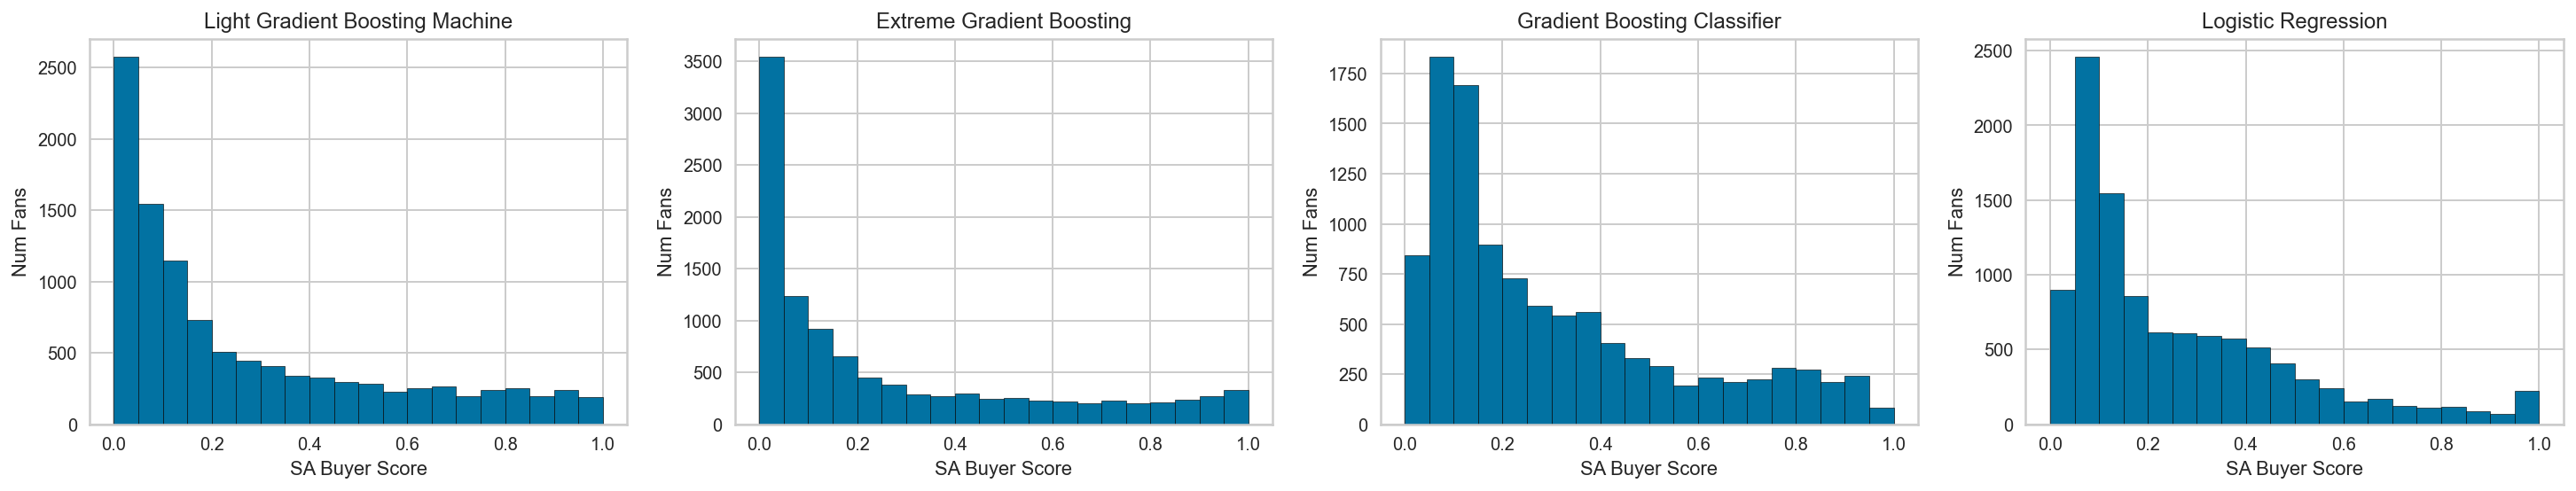

In [16]:
for idx, model in enumerate(models):
    
    plt.subplot(1, 4, idx+1)
    plt.title(model["name"])
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")
    plt.hist(model["predictions"]["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.rcParams["figure.figsize"] = (25,4)
plt.show()

### Select the model you would like to use for updating scores:

In [45]:
selected_model = "Extreme Gradient Boosting"

for model in models:
    if model["name"] == selected_model:

        df_predictions = model["predictions"]

# *** NEED TO PULL SCORING FROM STORED PROC, NOT FROM TRAINING DF ***

### Let's create some buckets of customers who got scored at different probabilities:

In [173]:
df_baseline = np.array_split(df_predictions, 1)
leads = np.array_split(df_predictions.sort_values(by="Score_1", ascending=False), 1)

df_baseline = df_baseline[0]
df_top_leads= leads[0]

print(len(df_baseline))
print(len(df_top_leads))

10656
10656


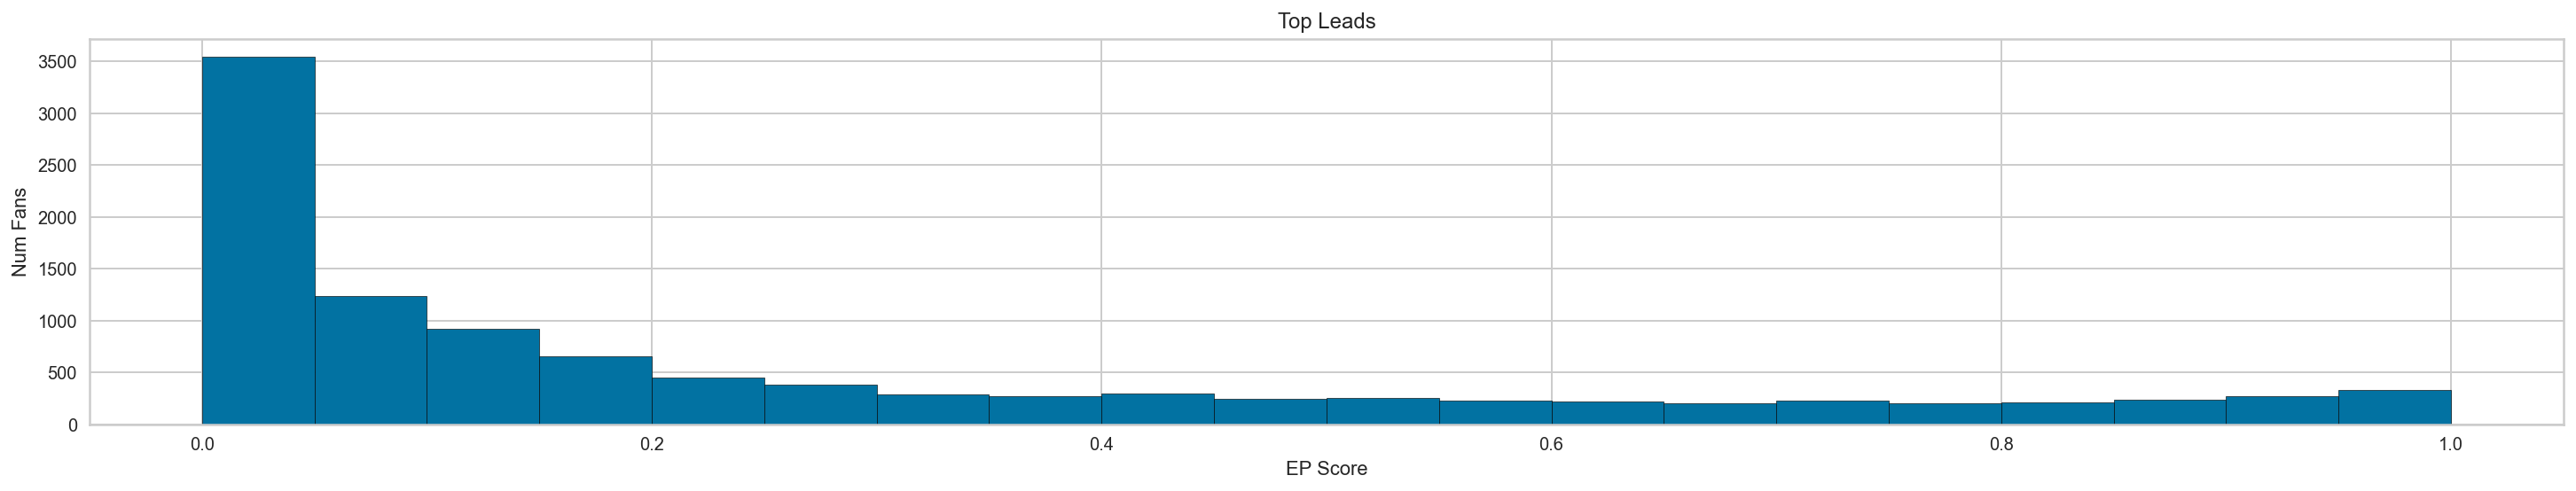

In [174]:
plt.title(f"Top Leads")
plt.ylabel("Num Fans")
plt.xlabel("EP Score")
plt.hist(df_top_leads["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.rcParams["figure.figsize"] = (25,4)
plt.show()

### Let's choose specific game and pull the actual ticket purchases:

In [175]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

MLGP-JJQB
Successully logged into Start URL: https://stellaralgo.awsapps.com/start


In [176]:
session = boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')
client = boto3.client('redshift')

cluster = 'qa-app'
dbname = 'stlrnhljets'
schema = 'dw'
table = 'cohortpurchase'
    
conn = wr.data_api.redshift.connect(
    cluster_id = cluster,
    database = dbname,
    db_user = "admin"
)

print("CREATED CONNECTION TO DATABASE")

CREATED CONNECTION TO DATABASE


In [177]:
#target_event = '20220429 - Calgary Flames'
target_event = '20220427 - Philadelphia Flyers'
#target_event = '20220413 - Seattle Kraken'
#target_event = '20220424 - Colorado Avalanche'
#target_event = '20220406 - Detroit Red Wings'

select_statement = f"""
    SELECT *
    FROM {dbname}.{schema}.{table}
    WHERE eventname = '{target_event}'
"""

#ADD and productGrouping = Individual

df_target_game = wr.data_api.redshift.read_sql_query(
    sql = select_statement, 
    con = conn
)

print(f"EVENT NAME: {target_event}")
print(f"TICKETS SOLD: {len(df_target_game)}")

EVENT NAME: 20220427 - Philadelphia Flyers
TICKETS SOLD: 7887


### Let's see if any of our top leads bought a ticket to our target game:

In [178]:
df_target_game['dimCustomerMasterId'] = df_target_game['dimcustomermasterid']

df_merged_baseline = pd.merge(df_baseline, df_target_game, on=['dimCustomerMasterId'], how='inner')
df_merged_top_leads = pd.merge(df_top_leads, df_target_game, on=['dimCustomerMasterId'], how='inner')

print("TICKETS MATCHED:")
print(f" {df_merged_baseline.shape[0]} - Baseline")
print(f" {df_merged_top_leads.shape[0]} -  Top Leads", end="\n\n")
      
print("CONVERSION RATE:")
print(f" +{((df_merged_top_leads.shape[0] - df_merged_baseline.shape[0]) / df_merged_baseline.shape[0]) * 100} %")


TICKETS MATCHED:
 169 - Baseline
 169 -  Top Leads

CONVERSION RATE:
 +0.0 %
